# Imports

In [185]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
from textblob import TextBlob
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import torch
from transformers import pipeline



#  Data Loading

In [186]:
# Load the dataset

# The dataset is stored in a CSV file named 'customers.csv'
df = pd.read_csv('customers.csv')

# Display the first few rows of the dataframe to understand its structure

df.head()

# Explanation:
# - pd.read_csv: Reads a CSV file into a DataFrame
# - df.head(): Displays the first few rows of the DataFrame to give a quick look at the data


,Date,Name,ID,Type,Review,Rating
0,2021-01-28,Stephanie Torres,M8UANEPY,business,Had some issues with transactions.,2
1,2021-11-26,Melissa Jones,T4IA10QD,business,The online banking app is user-friendly.,4
2,2022-09-01,Robert Crosby,7GRQ9DHR,business,Great service!,2
3,2019-11-08,Jeremiah Hernandez,9GKG0DQL,saving,The online banking app is user-friendly.,2
4,2022-06-05,April Harris,AN531P9A,business,Not happy with the fees.,4


# Data Cleaning

In [187]:
# Data Cleaning

# Check for missing values
missing_values = df.isnull().sum()

# Display the count of missing values in each column
print("Missing values in each column:\n", missing_values)

# If there are missing values, we need to handle them. For simplicity, let's drop rows with any missing values.
df_cleaned = df.dropna()

# Convert 'Date' column to datetime type
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Check for duplicate rows
duplicate_rows = df_cleaned.duplicated().sum()

# Display the count of duplicate rows
print("Number of duplicate rows:", duplicate_rows)

# Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Explanation:
# - df.isnull().sum(): Checks for missing values in each column
# - df.dropna(): Drops rows with any missing values
# - pd.to_datetime: Converts a column to datetime type
# - df.duplicated().sum(): Checks for duplicate rows
# - df.drop_duplicates(): Drops duplicate rows


Missing values in each column:
 Date      0
Name      0
ID        0
Type      0
Review    0
Rating    0
dtype: int64
Number of duplicate rows: 0


# Exploratory Data Analysis (EDA)
##      Using Built-in Methods

In [188]:
# Exploratory Data Analysis (EDA) using built-in methods

# Display summary statistics of the dataset
summary_stats = df_cleaned.describe()
print("Summary Statistics:\n", summary_stats)

# Display the count of unique customer types
customer_types = df_cleaned['Type'].value_counts()
print("\nCount of Unique Customer Types:\n", customer_types)

# Display the average rating
average_rating = df_cleaned['Rating'].mean()
print("\nAverage Rating:", average_rating)

# Explanation:
# - df_cleaned.describe(): Provides summary statistics of the dataset
# - df_cleaned['Type'].value_counts(): Counts the unique values in the 'Type' column
# - df_cleaned['Rating'].mean(): Calculates the average rating


Summary Statistics:
                              Date        Rating
count                       50000  50000.000000
mean   2022-01-20 14:15:21.600000      3.008640
min           2019-07-25 00:00:00      1.000000
25%           2020-10-23 00:00:00      2.000000
50%           2022-01-18 00:00:00      3.000000
75%           2023-04-23 00:00:00      4.000000
max           2024-07-22 00:00:00      5.000000
std                           NaN      1.415318

Count of Unique Customer Types:
 Type
business         12623
current          12562
fixed deposit    12422
saving           12393
Name: count, dtype: int64

Average Rating: 3.00864


<!-- Explanation of Statistical Terms
Count: The total number of non-null values in the dataset.
Mean: The average value of a numerical column.
Median (50%): The middle value when the values are sorted in ascending order. If there is an even number of values, it is the average of the two middle values.
Standard Deviation (std): A measure of the amount of variation or dispersion in a set of values.
Minimum (min): The smallest value in the dataset.
25% (Q1 or First Quartile): The value below which 25% of the data falls.
50% (Q2 or Median): The middle value of the dataset.
75% (Q3 or Third Quartile): The value below which 75% of the data falls. -->


# Exploratory Data Analysis (EDA)
##    Using Manual Calculations

In [189]:
# Exploratory Data Analysis (EDA) using manual calculations

# Function to calculate count
def manual_count(column):
    count = 0
    for _ in column:
        count += 1
    return count

# Function to calculate mean
def manual_mean(column):
    total = 0
    count = manual_count(column)
    for value in column:
        total += value
    return total / count if count != 0 else 0

# Function to calculate standard deviation
def manual_std(column):
    mean = manual_mean(column)
    total_squared_diff = 0
    count = manual_count(column)
    for value in column:
        total_squared_diff += (value - mean) ** 2
    variance = total_squared_diff / (count - 1) if count > 1 else 0
    return variance ** 0.5

# Function to calculate min
def manual_min(column):
    min_value = column[0]
    for value in column:
        if value < min_value:
            min_value = value
    return min_value

# Function to calculate max
def manual_max(column):
    max_value = column[0]
    for value in column:
        if value > max_value:
            max_value = value
    return max_value

# Function to calculate quantiles
def manual_quantile(column, quantile):
    sorted_column = sorted(column)
    index = (len(sorted_column) - 1) * quantile   # This index is computed as (length of column - 1) * quantile
    lower_index = int(index)
    upper_index = lower_index + 1    #The lower index is the integer part of the calculated index.
    weight = index - lower_index      #The upper index is the next integer after the lower index.
    if upper_index >= len(sorted_column):     #The weight is the fractional part of the index, which represents how far the index is between the lower and upper indices.
        return sorted_column[lower_index]
    return sorted_column[lower_index] * (1 - weight) + sorted_column[upper_index] * weight    # Interpolation is a method used to estimate values between two known values in a dataset

# Calculate summary statistics manually
summary_stats_manual = {
    "count": manual_count(df_cleaned['Rating']),
    "mean": manual_mean(df_cleaned['Rating']),
    "std": manual_std(df_cleaned['Rating']),
    "min": manual_min(df_cleaned['Rating']),
    "25%": manual_quantile(df_cleaned['Rating'], 0.25),
    "50%": manual_quantile(df_cleaned['Rating'], 0.50),
    "75%": manual_quantile(df_cleaned['Rating'], 0.75),
    "max": manual_max(df_cleaned['Rating'])
}
print("Summary Statistics (Manual Calculation):\n", summary_stats_manual)

# Display the count of unique customer types manually
customer_types_manual = {}
for customer_type in df_cleaned['Type']:
    if customer_type in customer_types_manual:
        customer_types_manual[customer_type] += 1
    else:
        customer_types_manual[customer_type] = 1
print("\nCount of Unique Customer Types (Manual Calculation):\n", customer_types_manual)

# Display the average rating manually
total_rating = 0
count_rating = 0
for rating in df_cleaned['Rating']:
    total_rating += rating
    count_rating += 1
average_rating_manual = total_rating / count_rating if count_rating != 0 else 0
print("\nAverage Rating (Manual Calculation):", average_rating_manual)

# Explanation:
# - summary_stats_manual: Calculates summary statistics using custom functions without built-in methods
# - customer_types_manual: Counts unique customer types using a dictionary and for loop
# - average_rating_manual: Calculates the average rating using a for loop


Summary Statistics (Manual Calculation):
 {'count': 50000, 'mean': 3.00864, 'std': 1.4153181313423453, 'min': 1, '25%': 2.0, '50%': 3.0, '75%': 4.0, 'max': 5}

Count of Unique Customer Types (Manual Calculation):
 {'business': 12623, 'saving': 12393, 'current': 12562, 'fixed deposit': 12422}

Average Rating (Manual Calculation): 3.00864


sorted_column = [1, 2, 3, 4, 5]

index = (5 - 1) * 0.25  # (5 is the length of the sorted column)

index = 4 * 0.25

index = 1.0

lower_index = int(1.0)  # lower_index = 1

upper_index = lower_index + 1  # upper_index = 2

weight = 1.0 - lower_index  # weight = 1.0 - 1 = 0.0

return sorted_column[lower_index]

## Date Column

In [190]:
# Convert Date column to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Calculate range of dates
date_min = df_cleaned['Date'].min()
date_max = df_cleaned['Date'].max()

# Calculate the number of unique dates
date_count = df_cleaned['Date'].nunique()

print("Date Range:", date_min, "to", date_max)
print("Number of Unique Dates:", date_count)
# Extract Year and Month
df_cleaned['Year'] = df_cleaned['Date'].dt.year
df_cleaned['Month'] = df_cleaned['Date'].dt.month

Date Range: 2019-07-25 00:00:00 to 2024-07-22 00:00:00
Number of Unique Dates: 1825


## Name Column

In [191]:
# Calculate the number of unique names
name_count = df_cleaned['Name'].nunique()

# Find the most common names
most_common_names = df_cleaned['Name'].value_counts().head(5)

print("Number of Unique Names:", name_count)
print("Most Common Names:\n", most_common_names)


Number of Unique Names: 40193
Most Common Names:
 Name
Michael Smith       23
Robert Williams     19
Michael Williams    18
David Smith         16
Michael Jones       16
Name: count, dtype: int64


## ID Column

In [192]:
# Calculate the number of unique IDs
id_count = df_cleaned['ID'].nunique()

# Check for duplicate IDs
duplicate_ids = df_cleaned['ID'].duplicated().sum()

print("Number of Unique IDs:", id_count)
print("Number of Duplicate IDs:", duplicate_ids)

Number of Unique IDs: 50000
Number of Duplicate IDs: 0


## Type Column


In [193]:
# Calculate the frequency of each customer type
type_counts = df_cleaned['Type'].value_counts()

# List unique customer types
unique_types = df_cleaned['Type'].unique()

print("Customer Type Counts:\n", type_counts)
print("Unique Customer Types:", unique_types)


Customer Type Counts:
 Type
business         12623
current          12562
fixed deposit    12422
saving           12393
Name: count, dtype: int64
Unique Customer Types: ['business' 'saving' 'current' 'fixed deposit']


# Visualization Section

## Date Column

Purpose: To understand how data entries are distributed over time and identify any temporal patterns or trends.

Line Plot: Shows the number of entries over time.

Count Plot: Displays the distribution of entries by year and month.
python


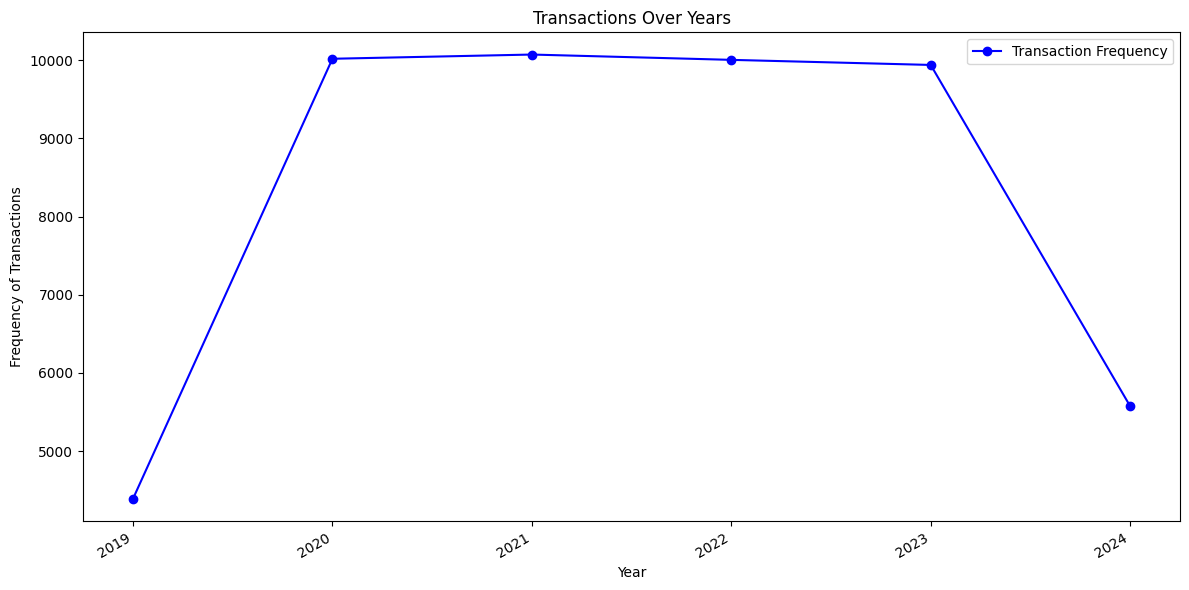

____________________


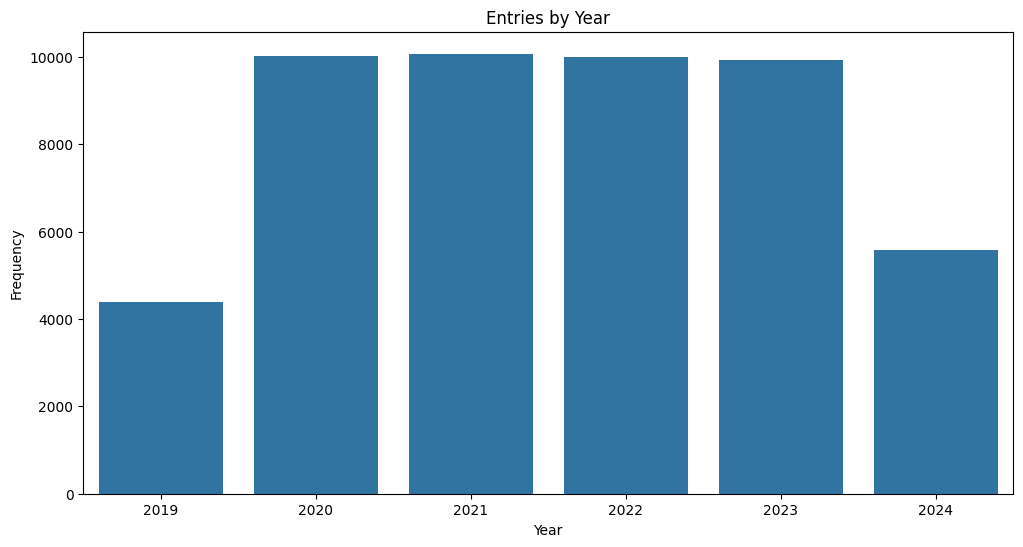

____________________


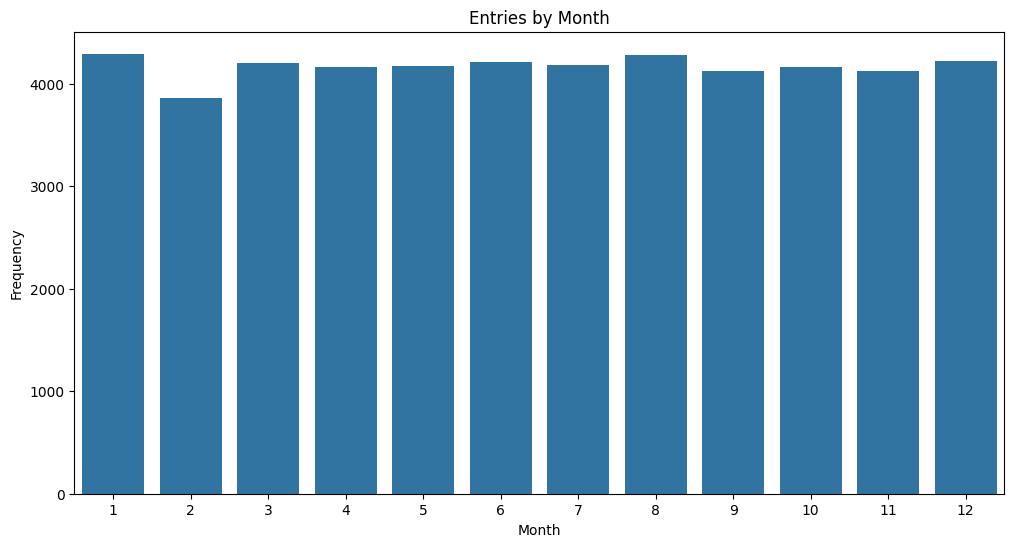

In [194]:
yearly_counts = df_cleaned['Year'].value_counts().sort_index()      #that 2022 appears 100 times.
years = yearly_counts.index                                         #the unique years
frequencies = yearly_counts.values
plt.figure(figsize=(12, 6))
plt.plot(years, frequencies, 'b-', marker='o', label='Transaction Frequency')  # Line plot with markers
plt.title('Transactions Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency of Transactions')
plt.xticks(years, rotation=30, ha='right')  # Rotate x-axis labels
plt.legend()
plt.tight_layout()
plt.show()
print('_'*20)

# Yearly Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x='Year', order=sorted(df_cleaned['Year'].unique()))
plt.title('Entries by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()
print('_'*20)

# Monthly Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x='Month', order=sorted(df_cleaned['Month'].unique()))
plt.title('Entries by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

##  Type Column
Purpose: To analyze the distribution of customer types and their proportions.

Bar Plot: To visualize the frequency of each customer type.

Pie Chart: To show the proportional distribution of customer types.

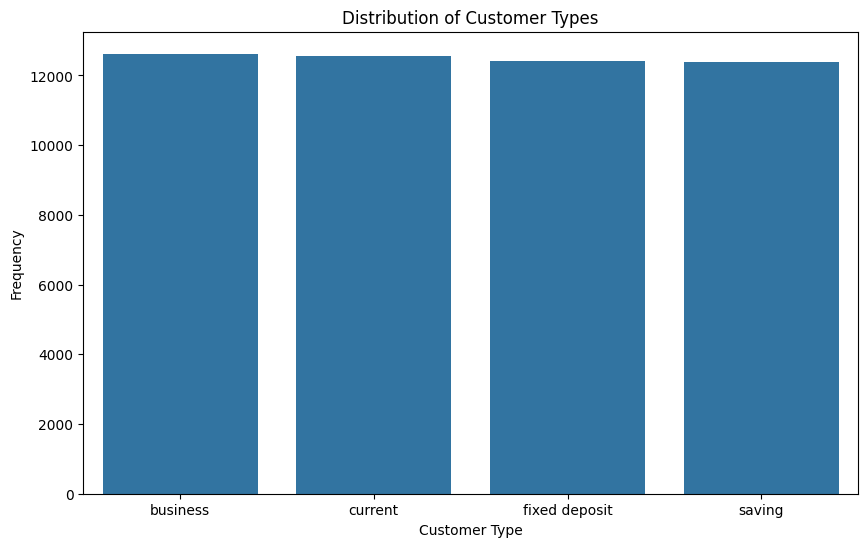

____________________


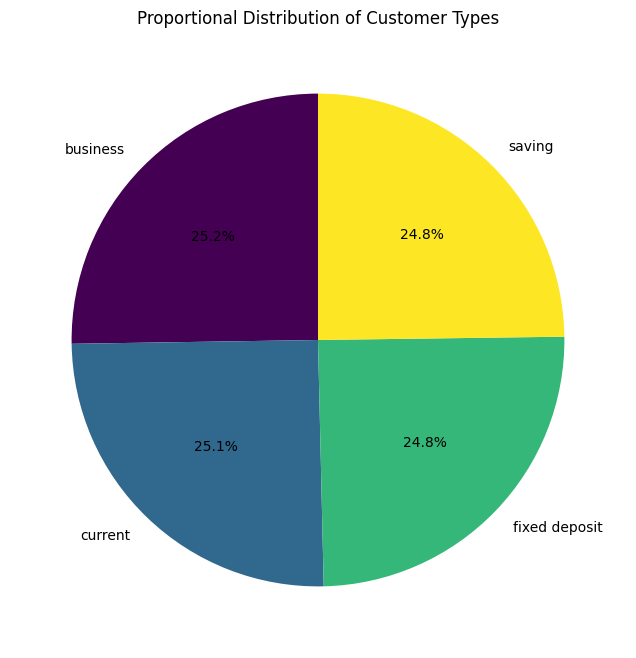

In [195]:
# Bar Plot of Customer Types
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='Type', order=df_cleaned['Type'].value_counts().index)
plt.title('Distribution of Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Frequency')
plt.show()
print('_'*20)
# Proportional Distribution
type_proportion = df_cleaned['Type'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
type_proportion.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Proportional Distribution of Customer Types')
plt.ylabel('')
plt.show()

# Explanation:
# - The bar plot shows the frequency of each customer type, making it easy to compare categories.
# - The pie chart provides a proportional view of each customer type, illustrating their relative importance.



## Rating Column

Purpose: To understand the distribution and variability of customer ratings.

Histogram with KDE Plot: To visualize the distribution of ratings.

Box Plot: To highlight the spread of ratings, including median, quartiles, and outliers.

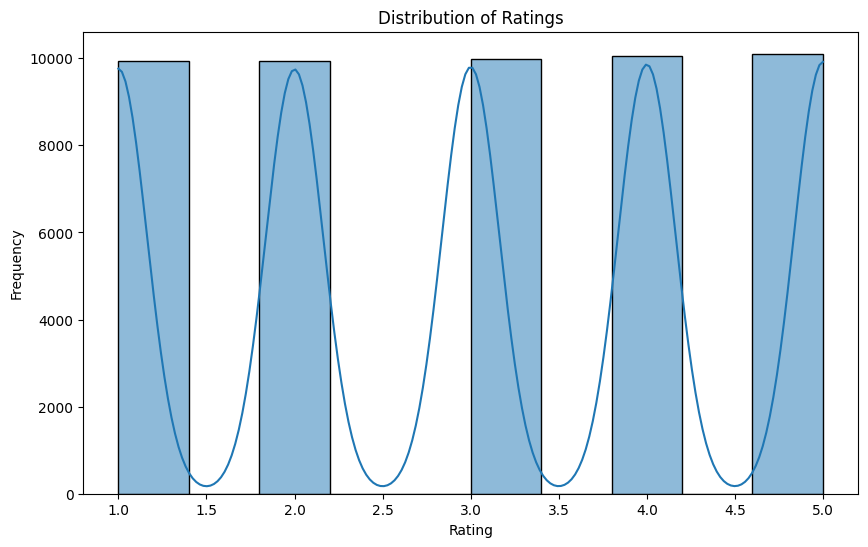

____________________


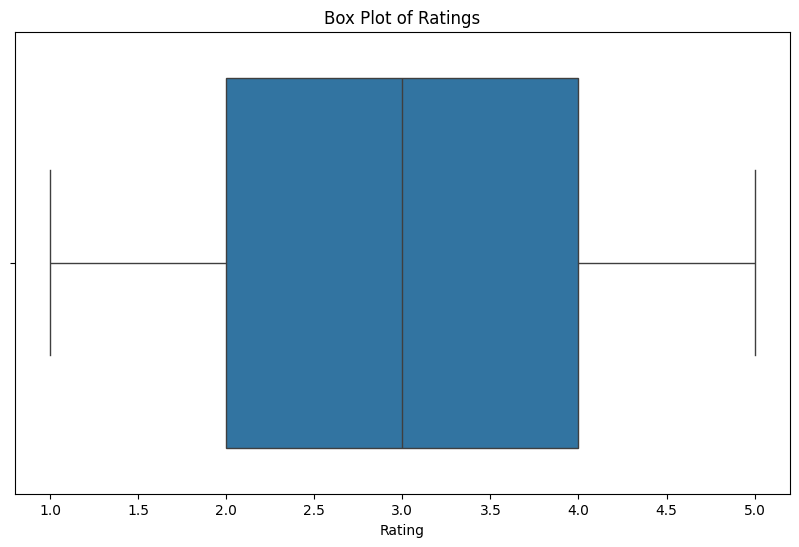

In [196]:
# Histogram and KDE Plot of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()
print('_'*20)
# Box Plot of Ratings
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='Rating')
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

# Explanation:
# - The histogram with KDE plot shows the distribution of ratings, highlighting the frequency of each rating and the overall shape of the distribution.
# - The box plot visualizes the spread of ratings, including the median, quartiles, and potential outliers, which helps in understanding the central tendency and variability.


# Reviews

## Cleaning

In [197]:
stop_words = set(STOP_WORDS)
df_cleaned['Review'] = df_cleaned['Review'].str.lower()  # Convert to lowercase
df_cleaned['Review'] = df_cleaned['Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove punctuation     re.sub(r'[^\w\s]', '', x) removes all punctuation and special characters from the string x, leaving only alphanumeric characters and whitespace.

# Remove stopwords using spaCy
df_cleaned['Review'] = df_cleaned['Review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
df_cleaned


,Date,Name,ID,Type,Review,Rating,Year,Month
0,2021-01-28,Stephanie Torres,M8UANEPY,business,issues transactions,2,2021,1
1,2021-11-26,Melissa Jones,T4IA10QD,business,online banking app userfriendly,4,2021,11
2,2022-09-01,Robert Crosby,7GRQ9DHR,business,great service,2,2022,9
3,2019-11-08,Jeremiah Hernandez,9GKG0DQL,saving,online banking app userfriendly,2,2019,11
4,2022-06-05,April Harris,AN531P9A,business,happy fees,4,2022,6
...,...,...,...,...,...,...,...,...
49995,2024-02-09,Stephanie Hernandez,FJ3A10QV,fixed deposit,online banking app userfriendly,2,2024,2
49996,2022-11-08,Nathan Henson,W2TVY3GH,current,issues transactions,4,2022,11
49997,2020-04-04,Teresa Williams,L8GWXSAZ,saving,customer service needs improvement,2,2020,4
49998,2023-04-28,Linda Carney,BO82C0HL,fixed deposit,excellent customer service,5,2023,4


## Text Cleaning

### manula


In [198]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text
df_cleaned['Cleaned_Review'] = df_cleaned['Review'].apply(clean_text)

### Aplly model 

In [199]:
nlp = spacy.load("en_core_web_sm")    #spacy.load("en_core_web_sm"): This line loads the small English language model provided by spaCy.
def preprocess_text(text):
    doc = nlp(text)
    # Remove stopwords and punctuation, and lemmatize the words
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Apply preprocessing to the 'Review' column
df_cleaned['Cleaned_Review'] = df_cleaned['Review'].apply(preprocess_text)

# Check the results
print(df_cleaned[['Review', 'Cleaned_Review']].head())

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


                            Review                   Cleaned_Review
0              issues transactions                issue transaction
1  online banking app userfriendly  online banking app userfriendly
2                    great service                    great service
3  online banking app userfriendly  online banking app userfriendly
4                       happy fees                        happy fee


# EDA Reviews

In [200]:

# Tokenize the reviews into words
all_words = ' '.join(df_cleaned['Cleaned_Review']).split()
word_freq = Counter(all_words)                              #This creates a Counter object called word_counts that counts the occurrences of each element (word) in the all_words list

# Convert to DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Display the most common words
print(word_freq_df.head(10))


            Word  Frequency
7        service      14745
10      customer       9844
5   userfriendly       5096
3        banking       5096
4            app       5096
2         online       5096
18       account       5052
16         quick       5052
17          easy       5052
19         setup       5052


### Check NUll

In [201]:


# Check the number of reviews
print("Number of reviews:", len(df_cleaned))

# Check for missing values
print("Missing values in 'Review' column:", df_cleaned['Review'].isnull().sum())


Number of reviews: 50000
Missing values in 'Review' column: 0


### N-Grams

In [202]:


# Function to extract n-grams
def get_ngrams(text_series, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))                #CountVectorizer: This is a class from scikit-learn used to convert a collection of text documents to a matrix of token counts. Essentially, it tokenizes the text and builds a vocabulary of known words
    X = vectorizer.fit_transform(text_series)   #fit: Learns the vocabulary dictionary of all n-grams from the provided text data (text_series).
                                                    #transform: Transforms the text data into a sparse matrix of n-gram counts.

    ngrams = vectorizer.get_feature_names_out()        
    counts = X.sum(axis=0).A1                           #X: The result is a sparse matrix where each row corresponds to a document and each column corresponds to an n-gram. The values in the matrix represent the counts of each n-gram in the respective document.
    return pd.DataFrame({'N-gram': ngrams, 'Frequency': counts}).sort_values(by='Frequency', ascending=False)

# Get and display bi-grams
bigrams_df = get_ngrams(df_cleaned['Cleaned_Review'], n=2)
print(bigrams_df.head(10))

# Get and display tri-grams
trigrams_df = get_ngrams(df_cleaned['Cleaned_Review'], n=3)
print(trigrams_df.head(10))


               N-gram  Frequency
5    customer service       9844
1    app userfriendly       5096
13     online banking       5096
2         banking app       5096
0       account setup       5052
6        easy account       5052
14         quick easy       5052
3     branch location       5043
4   convenient branch       5043
9           happy fee       5042
                       N-gram  Frequency
0    banking app userfriendly       5096
6          online banking app       5096
3          easy account setup       5052
7          quick easy account       5052
1  convenient branch location       5043
5          interest rate well       4972
4  excellent customer service       4947
2       customer service need       4897
8    service need improvement       4897


# Visualization

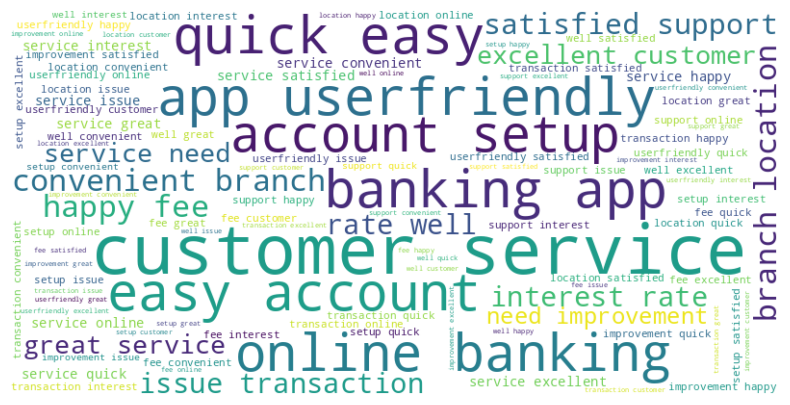

In [203]:


# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_cleaned['Cleaned_Review']))

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment  Analysis

#### Loading Bert Model

In [204]:

# Load the pre-trained BERT model for sentiment analysis
# Function to get sentiment from BERT model
device = 0 if torch.cuda.is_available() else -1

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analyzer = pipeline("sentiment-analysis", model=model_name, device=device)


In [205]:
def get_sentiment(text):
    result = sentiment_analyzer(text)[0]
    return result['label'], result['score']

# Initialize columns for sentiment labels and scores
df_cleaned['Sentiment_Label'] = ""
df_cleaned['Sentiment_Score'] = 0.0

# Process data in batches to avoid memory issues
batch_size = 100  # Adjust the batch size as needed

for start in range(0, len(df_cleaned), batch_size):
    end = min(start + batch_size, len(df_cleaned))
    batch_reviews = df_cleaned['Review'].iloc[start:end]
    sentiments = batch_reviews.apply(lambda x: pd.Series(get_sentiment(x)))
    df_cleaned.iloc[start:end, df_cleaned.columns.get_loc('Sentiment_Label')] = sentiments[0].values
    df_cleaned.iloc[start:end, df_cleaned.columns.get_loc('Sentiment_Score')] = sentiments[1].values

df_cleaned


,Date,Name,ID,Type,Review,Rating,Year,Month,Cleaned_Review,Sentiment_Label,Sentiment_Score
0,2021-01-28,Stephanie Torres,M8UANEPY,business,issues transactions,2,2021,1,issue transaction,NEGATIVE,0.985956
1,2021-11-26,Melissa Jones,T4IA10QD,business,online banking app userfriendly,4,2021,11,online banking app userfriendly,NEGATIVE,0.979013
2,2022-09-01,Robert Crosby,7GRQ9DHR,business,great service,2,2022,9,great service,POSITIVE,0.999843
3,2019-11-08,Jeremiah Hernandez,9GKG0DQL,saving,online banking app userfriendly,2,2019,11,online banking app userfriendly,NEGATIVE,0.979013
4,2022-06-05,April Harris,AN531P9A,business,happy fees,4,2022,6,happy fee,POSITIVE,0.999876
...,...,...,...,...,...,...,...,...,...,...,...
49995,2024-02-09,Stephanie Hernandez,FJ3A10QV,fixed deposit,online banking app userfriendly,2,2024,2,online banking app userfriendly,NEGATIVE,0.979013
49996,2022-11-08,Nathan Henson,W2TVY3GH,current,issues transactions,4,2022,11,issue transaction,NEGATIVE,0.985956
49997,2020-04-04,Teresa Williams,L8GWXSAZ,saving,customer service needs improvement,2,2020,4,customer service need improvement,NEGATIVE,0.996753
49998,2023-04-28,Linda Carney,BO82C0HL,fixed deposit,excellent customer service,5,2023,4,excellent customer service,POSITIVE,0.999850


### Summary of Analysis

In [206]:
print(df_cleaned['Sentiment_Label'].value_counts())

Sentiment_Label
POSITIVE    34984
NEGATIVE    15016
Name: count, dtype: int64


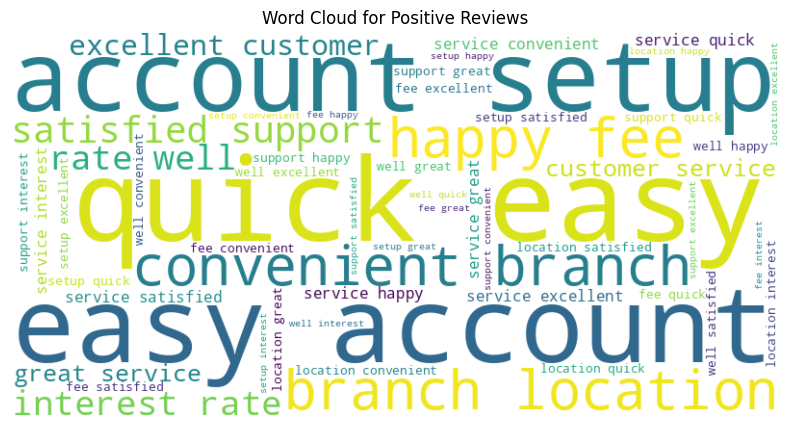

--------------------


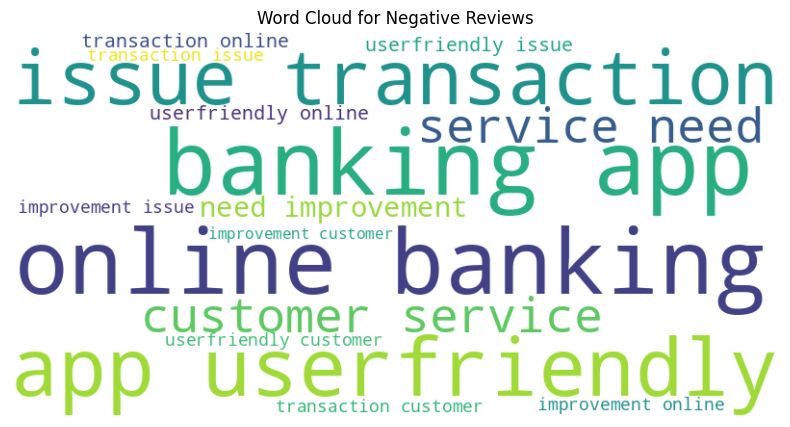

--------------------


In [207]:
positive_reviews = df_cleaned[df_cleaned['Sentiment_Label'] == 'POSITIVE']['Cleaned_Review']
negative_reviews = df_cleaned[df_cleaned['Sentiment_Label'] == 'NEGATIVE']['Cleaned_Review']

# Generate word clouds for each sentiment
def generate_wordcloud(text_series, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    print("-"*20)

generate_wordcloud(positive_reviews, 'Word Cloud for Positive Reviews')
generate_wordcloud(negative_reviews, 'Word Cloud for Negative Reviews')